This notebook will train an XGBoost regression model to predict dam fullness
you may not need to run this if you already have the model from the repo

In [35]:
from datetime import datetime
import pickle
import json
import glob
import os

from sklearn.metrics import mean_absolute_error, mean_tweedie_deviance, mean_absolute_percentage_error
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [2]:
# path to training and validation data
training_data_path = os.path.join(os.getcwd(),'data/dam forecast train.csv')

val_data_path = os.path.join(os.getcwd(),'data/dam forecast val.csv')

In [3]:
# set location to save model
model_folder = os.getcwd()
model_name = 'dam_forecast_11-10-22.pkl'
model_path = os.path.join(model_folder,'data',model_name)
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'

In [4]:
# we limit the max dam size as large dams are note well represented in our dataset 
max_value = 20000

In [5]:
# load up training data, do some cleaning/sorting
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = (training_data[training_data['dam_area'] < max_value])
training_data.replace([np.inf, -np.inf], 0, inplace=True)
training_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20191216,2019.923077,12,2019,2,no water,1499.986376,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),2.762451,...,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695,0.000000
1,20191216,2019.923077,12,2019,2,no water,1957.925202,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),3.197464,...,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044,0.000000
2,20191216,2019.923077,12,2019,2,no water,56.557682,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),2.658848,...,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549,0.000000
3,20191216,2019.923077,12,2019,0,dam and water,620.839041,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),4.103868,...,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342,69.919793
4,20191216,2019.923077,12,2019,0,dam and water,911.591665,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),3.889048,...,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476,85.853539


In [6]:
# load up validation data and do some cleaning/sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = (val_data[val_data['dam_area'] < max_value])
val_data.replace([np.inf, -np.inf], 0, inplace=True)
val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20151012,2015.769231,10,2015,0,dam and water,1467.191148,arcgisonline_132898_pred_and_score.tif,POINT (117.3172965191077 -33.24564247144878),9.043823,...,12.835136,11.108263,10.531229,12.044368,12.067635,16.236391,20.395378,24.588543,23.805340,400.256079
1,20160808,2016.615385,8,2016,0,dam and water,7575.018970,arcgisonline_70618_pred_and_score.tif,POINT (152.9625759629707 -26.43549796464562),30.879414,...,16.208225,16.421938,19.850100,22.161938,24.166159,25.166771,24.075779,23.361519,23.210749,5781.220903
2,20150329,2015.230769,3,2015,0,dam and water,2028.126533,arcgisonline_84979_pred_and_score.tif,POINT (142.9804044837108 -37.77391478774938),22.954985,...,20.310444,18.668152,16.997301,15.661266,13.949310,11.053338,8.662997,8.203583,9.625609,581.212166
3,20151215,2015.923077,12,2015,0,dam and water,569.161178,arcgisonline_101081_pred_and_score.tif,POINT (145.618767566165 -38.4325091507143),37.716213,...,15.805417,15.925524,11.613432,9.590775,9.022965,10.216203,12.452333,14.021166,16.439243,317.463008
4,20160416,2016.307692,4,2016,0,dam and water,3367.296500,arcgisonline_125002_pred_and_score.tif,POINT (118.0078021793126 -30.57147183423009),31.052204,...,24.274788,26.393480,26.532434,24.433882,23.749607,21.477095,14.928035,12.299461,11.371953,508.559500


In [7]:
training_data.shape

(108847, 36)

In [8]:
val_data.shape

(12092, 36)

In [9]:
# set a list of columns to drop, the model will not see these
drop_list = ['water_area','file_name', 'SRC_DATE','geometry','acq_year','acq_month','acq_date_dec','class','class_name']

In [10]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[['water_area']]
print(train_y.head())
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [11]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[['water_area']].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539
(108847, 27)


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [12]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {'col_names':list(train_X.columns),
            'model_path':model_path,
            'creation_date':str(datetime.today().strftime('%Y-%m-%d'))}

with open(model_path.replace('.pkl','.json'), 'w') as fp:
    json.dump(meta_dict, fp)

In [13]:
train_X.sample(frac=.8)

,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
26995,775.988124,72.991013,29.380165,49.447170,138.327286,137.783112,103.730728,82.920120,51.960526,72.882050,...,7.536523,8.352099,8.191304,11.402054,14.787170,18.430862,19.026196,19.188116,19.348360,15.076445
59405,2481.611794,81.785172,1.173700,32.938927,60.579540,34.756084,84.375999,13.918946,24.479218,76.830353,...,24.263981,24.047546,21.073580,19.815149,11.627159,9.192934,7.905071,8.491185,12.132092,16.470284
27155,855.391738,93.234047,66.685081,156.883728,48.025669,64.584686,219.353149,9.786948,44.619240,79.723686,...,13.844188,13.522468,14.383385,17.339272,20.288031,22.584753,23.704046,22.804090,21.717405,21.513531
86252,10082.850896,58.486889,120.424423,62.336330,31.100023,79.997925,38.924889,60.113361,29.427406,47.147499,...,24.473604,22.765078,21.683317,19.765614,16.079140,11.527958,8.361680,7.465248,9.083667,12.128974
95080,18487.327855,184.276398,58.253345,38.564941,32.596107,13.883340,22.238722,97.680786,29.433630,0.180042,...,27.854841,28.390816,23.751678,19.174236,16.136648,14.182662,16.540766,19.529924,23.824417,26.346199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23077,3229.216021,56.650311,48.960274,74.906303,46.593475,184.723801,71.464676,92.751236,142.661148,65.873184,...,20.768709,11.925475,9.513663,9.394897,9.886133,12.984982,19.421558,23.676821,24.901487,24.995451
86957,192.793854,72.861389,32.866848,15.122061,21.818676,33.809372,23.261782,24.218056,29.559916,44.840816,...,20.593336,16.886354,15.968460,14.371208,11.957579,9.598118,9.154391,10.568137,13.173036,14.731196
83402,1909.104298,28.184416,27.073822,98.714546,29.467249,82.986282,63.189735,13.045634,13.735751,13.566582,...,26.762405,24.547163,24.709784,23.251471,19.297930,13.633472,9.688606,8.985215,10.329751,14.240148
37449,1012.415779,39.391197,23.962896,49.581200,105.638016,26.984446,2.304692,76.323280,31.522619,83.660629,...,15.367590,22.123236,23.471235,23.358990,22.059471,19.643543,18.091133,10.637012,8.538913,6.628183


In [14]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'

In [15]:
# func to train a model using variable inputs
def train_model(learning_rate,n_estimators,max_depth):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,
                               tree_method='hist',
                               objective='reg:tweedie',
                              )
    xgb_reg.fit(train_X, train_y,verbose = 0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred*(y_pred>0)
    
    model_mean_error = mean_absolute_error(val_data['water_area'].to_numpy(), y_pred)
                
    return(-model_mean_error)

In [19]:
# set the bounds for optimization search
pbounds = {'learning_rate': (0.1, 0.5), 'n_estimators': (10, 700),'max_depth': (1,10)}

In [20]:
# setup optimizer
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [21]:
# run optimizer
optimizer.maximize(
    init_points=15,
    n_iter=30,
)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -948.6    |  0.2668   |  7.483    |  10.08    |
|  2        | -367.1    |  0.2209   |  2.321    |  73.71    |
|  3        | -335.6    |  0.1745   |  4.11     |  283.8    |
|  4        | -342.1    |  0.3155   |  4.773    |  482.8    |
|  5        | -443.6    |  0.1818   |  8.903    |  28.9     |
|  6        | -340.3    |  0.3682   |  4.756    |  395.5    |
|  7        | -337.0    |  0.1562   |  2.783    |  562.5    |
|  8        | -340.6    |  0.4873   |  3.821    |  487.7    |
|  9        | -358.6    |  0.4506   |  9.051    |  68.68    |
|  10       | -338.0    |  0.1156   |  2.528    |  615.9    |
|  11       | -332.0    |  0.1393   |  4.79     |  670.9    |
|  12       | -345.8    |  0.3133   |  7.227    |  227.7    |
|  13       | -351.5    |  0.3746   |  8.512    |  22.62    |
|  14       | -413.4    |  0.4001   |  9.9      |  526.2    |
|  15   

In [22]:
# show best vars
# best_pers = optimizer.max
# best_pers

In [23]:
def train_fin_model(learning_rate,n_estimators,max_depth):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,                        
                               tree_method='hist',
                               objective='reg:tweedie',
                              )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)
    
    return(xgb_reg)

In [24]:
model_count = 10

In [25]:
top_5_models = pd.DataFrame(optimizer.res).sort_values('target', ascending=[False]).head(model_count)
top_5_models

,target,params
10,-331.979751,"{'learning_rate': 0.13933873353322004, 'max_de..."
2,-335.594029,"{'learning_rate': 0.17450408455106836, 'max_de..."
18,-336.167163,"{'learning_rate': 0.23539515374164766, 'max_de..."
6,-336.974829,"{'learning_rate': 0.15615477543809353, 'max_de..."
9,-338.042929,"{'learning_rate': 0.11562191329315295, 'max_de..."
33,-340.234663,"{'learning_rate': 0.27360468541012867, 'max_de..."
5,-340.261031,"{'learning_rate': 0.36818700407136096, 'max_de..."
14,-340.601302,"{'learning_rate': 0.2121775968257621, 'max_dep..."
7,-340.617608,"{'learning_rate': 0.48730463028775906, 'max_de..."
3,-342.129260,"{'learning_rate': 0.3155266936013428, 'max_dep..."


In [26]:
models = []
for row, model_hyps in tqdm(top_5_models.iterrows(),total=model_count):
    models.append({'model_number':str(row),
                   'model':train_fin_model(**model_hyps['params'])})

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
preds = pd.DataFrame()
for model in models:
    y_pred = model['model'].predict(val_X)
    y_pred = y_pred*(y_pred>0)
    preds[model['model_number']] = y_pred
    

In [28]:
preds

,10,2,18,6,9,33,5,14,7,3
0,270.097382,290.915192,271.822113,286.658569,305.285156,301.805176,281.548065,307.347260,300.100464,233.713348
1,4175.181641,4393.143066,4362.582031,4055.668701,4073.526855,4650.627441,4166.939453,4178.631348,3991.215332,4014.244873
2,424.696747,537.809387,444.760559,564.933777,486.332245,537.067993,385.123718,506.618591,272.271973,360.847656
3,225.936447,227.855225,220.686951,222.071182,228.856567,217.238480,210.892380,219.798904,219.502502,228.936020
4,905.709534,952.402588,1031.342163,965.842346,983.724121,922.465698,466.040619,869.564514,954.047546,1053.350220
...,...,...,...,...,...,...,...,...,...,...
12087,4252.643555,3949.798096,3831.847900,3751.216553,3966.724854,4230.222656,3926.160889,3989.928955,4340.400391,4316.800293
12088,228.194794,222.104752,232.060944,195.889023,201.896454,213.068207,237.601501,226.813278,192.909439,215.022018
12089,1078.905273,1291.268188,1360.300293,1727.636841,1502.062988,1419.802612,1514.278442,1235.016602,1137.738770,1524.959839
12090,1304.855591,1185.176147,1248.782471,1314.404541,1360.747925,1370.794800,1285.305786,1170.479614,1243.505249,1345.581177


In [29]:
val_y['preds'] = preds.mean(axis=1).to_list()

In [30]:
val_y

,water_area,preds
0,400.256079,284.929291
1,5781.220903,4206.176270
2,581.212166,452.046295
3,317.463008,222.177460
4,508.559500,910.448914
...,...,...
12230,5955.113008,4055.574707
12231,106.330725,216.556030
12232,2320.997848,1379.197021
12233,1341.055972,1282.963257


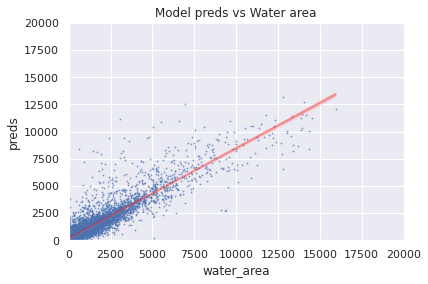

In [31]:
# plot up validation data preds vs measured values
ax = sns.regplot(x="water_area", y="preds", data=val_y,
                 scatter_kws={'s':1, 'alpha':0.5},
                 line_kws={"color": "red",'alpha':0.3}
                )
sns.set(rc={"figure.figsize":(8, 8)})
ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))
ax.set(title='Model preds vs Water area');

In [32]:
# use numpy to calc the line of best fit equation
# note this this looks much better than the scaled factor above
grad, y_intersect = np.polyfit(val_y['water_area'], val_y['preds'], 1)
grad, y_intersect

(0.831477258194092, 166.61335628074255)

In [33]:
# significant improvment from scaled factor above
model_mea = mean_absolute_error(val_y['water_area'], val_y['preds'])
model_mea

329.32451585984194

In [45]:
np.mean(np.abs((val_y['water_area'] - val_y['preds']) / y_true)) * 100

In [56]:
abs_error = np.mean(np.abs(val_y['water_area'] - val_y['preds'])/val_y['preds'])*100
abs_error

45.44346104195547

In [41]:
model_improvment = 1-(model_mea/466.89)
print(f'the model is {round(model_improvment*100)}% better than the scaled dam area') 

the model is 29% better than the scaled dam area


In [42]:
model_improvment = 1-(model_mea/885.85)
print(f'the model is {round(model_improvment*100)}% better than always guessing water area mean') 

the model is 63% better than always guessing water area mean


In [43]:
# save model to disk
# pickle.dump(xgb_reg, open(model_path, "wb"))
pickle.dump(models, open(model_path, "wb"))

In [44]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'